In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
%matplotlib inline
import scipy
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

plt.style.use('ggplot')                      
plt.rcParams['figure.figsize'] = (15, 10)

In [3]:
df = pd.read_csv('/Users/tsukinis/Downloads/data_test.csv', encoding = 'cp1251')

In [4]:
df.head()

,battle_id,unit_1,unit_2,unit_3,unit_4,len,balance_mark
0,103921,топор,лук,булава,лук,17.35,before
1,117214,посох,посох,лук,лук,21.84,before
2,115502,меч,посох,булава,топор,16.00,before
3,110102,булава,лук,лук,булава,17.22,before
4,104989,меч,посох,булава,посох,19.20,before


In [5]:
df.dtypes

battle_id         int64
unit_1           object
unit_2           object
unit_3           object
unit_4           object
len             float64
balance_mark     object
dtype: object

In [6]:
df.rename(columns = {'len':'length_of_battle'}, inplace = True) # для более удобного чтения

In [7]:
df.head()

,battle_id,unit_1,unit_2,unit_3,unit_4,length_of_battle,balance_mark
0,103921,топор,лук,булава,лук,17.35,before
1,117214,посох,посох,лук,лук,21.84,before
2,115502,меч,посох,булава,топор,16.00,before
3,110102,булава,лук,лук,булава,17.22,before
4,104989,меч,посох,булава,посох,19.20,before


In [8]:
df.balance_mark.value_counts()

before    10000
after     10000
Name: balance_mark, dtype: int64

Проведем A/B тестирование - разобьем данные на *Before* / *After*

In [9]:
x = df.query('balance_mark == "before"')['length_of_battle'].reset_index()
x.drop(columns = 'index', inplace = True)

In [10]:
y = df.query('balance_mark == "after"')['length_of_battle'].reset_index()
y.drop(columns = 'index', inplace = True)
y

,length_of_battle
0,23.30
1,27.12
2,26.06
3,22.76
4,28.40
...,...
9995,26.37
9996,23.73
9997,27.73
9998,24.20


In [11]:
df = x.join(y, lsuffix='_before', rsuffix='_after', how = 'outer')
df.tail(20)

,length_of_battle_before,length_of_battle_after
9980,16.42,20.23
9981,23.75,23.47
9982,22.20,20.08
9983,20.14,26.01
9984,20.00,28.71
9985,15.31,22.88
9986,21.54,7.01
9987,19.06,28.23
9988,20.41,25.64
9989,24.10,20.99


In [12]:
df = pd.DataFrame(df)
df.head()

,length_of_battle_before,length_of_battle_after
0,17.35,23.30
1,21.84,27.12
2,16.00,26.06
3,17.22,22.76
4,19.20,28.40


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Testgroup = After (length_of_battle)')

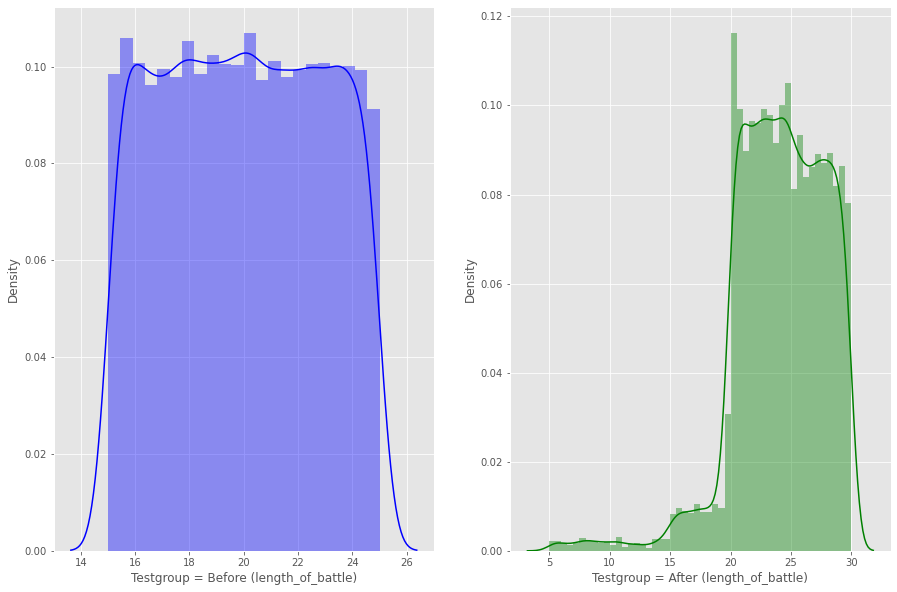

In [13]:
plt.subplot(1, 2, 1)
sns.distplot(df.length_of_battle_before, color='blue')
plt.xlabel('Testgroup = Before (length_of_battle)')

plt.subplot(1, 2, 2)
sns.distplot(df.length_of_battle_after, color='green')
plt.xlabel('Testgroup = After (length_of_battle)')

Исходя из дистограмм, можно сделать следюущий вывод:
<br>
В контрольной группе (Testgroup = After (length_of_battle)) присутствуют заметные выбросы - распределение заметно ненормальное


Есть конкретная разница во времени - сделать парное сравнение путем t-теста Стьюдента не получится.
<br>
В таком случае используем критерий Манна-Уитни - он устойчив к выбросам.

In [14]:
statistic, pvalue = scipy.stats.mannwhitneyu(df.length_of_battle_before, df.length_of_battle_after) 
print('statistic = ', statistic)
print('p-value = ', pvalue.round(3))

statistic =  18203684.0
p-value =  0.0


При p-value значительно близок к 0 => можем смело утверждать, что
<br> разница в длительности боя в 5% между группами является статистически значимой.
<br> Однако критерий Манна-Уитни не показывает нам, где именно находятся различия - для этого используем Бутстрап и будем сравнивать медианы групп.

In [15]:
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
                                ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
                                ).values
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)   
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
                    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
                    )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

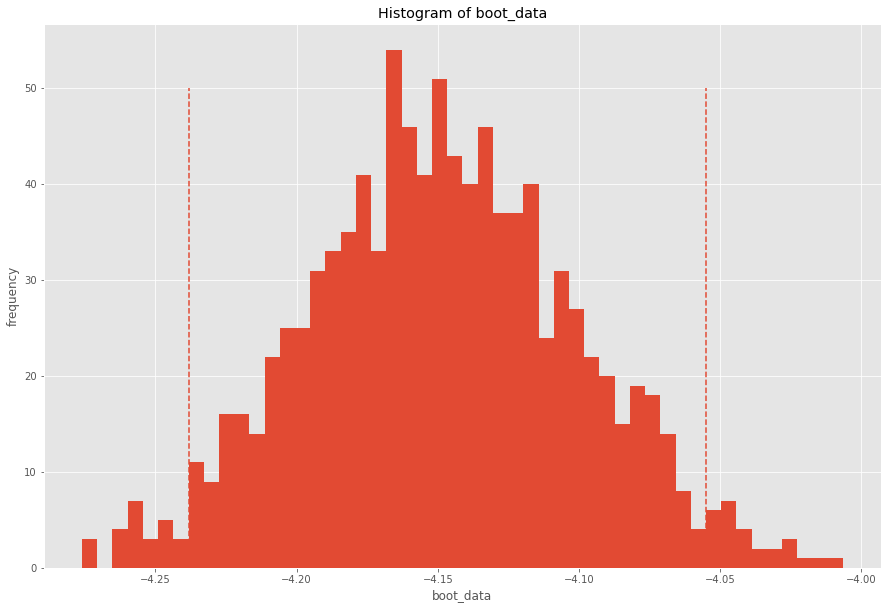

In [16]:
booted_data = get_bootstrap_mean(df.length_of_battle_before, df.length_of_battle_after) # в результате хранится разница двух распределений, ДИ и pvalue

In [17]:
booted_data["p_value"]

0.0

In [18]:
booted_data["quants"]

,0
0.025,-4.238177
0.975,-4.054953


Поскольку p-value < 0.05 и 0 **не** попадает в доверительный интервал это означает, что
<br> значимые статистическе различия **присутствуют**.

Критерий Манна-Уитни также позволяет отвергнуть нулевую гипотезу о равенстве средних (в случае со средними в бутстрепе результат идентичен).